Episodes: 341 Individuals: 1
Delta rows: 303 Trips: 38


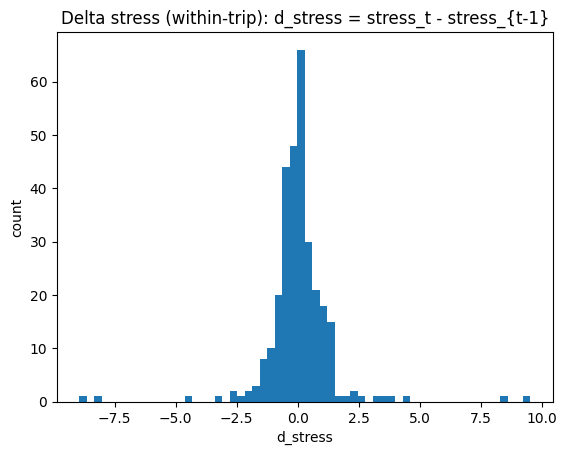

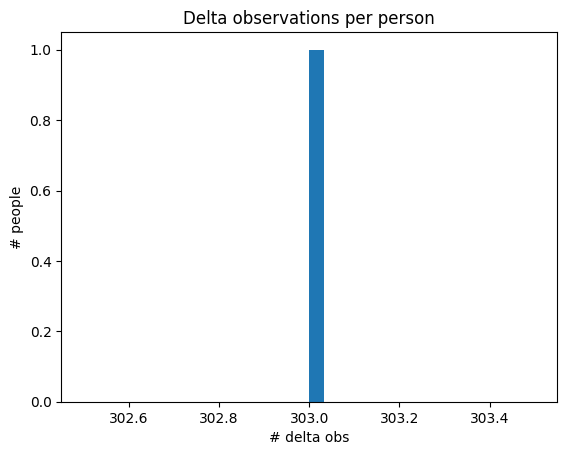

                            WLS Regression Results                            
Dep. Variable:               d_stress   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.1103
Date:                Wed, 14 Jan 2026   Prob (F-statistic):              0.979
Time:                        23:07:43   Log-Likelihood:                -529.50
No. Observations:                 303   AIC:                             1069.
Df Residuals:                     298   BIC:                             1088.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0564 

In [ ]:
# --- Imports ---
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Paths ---
stress_path = "/home/s232713/data/gps_trip_stress.csv"
env_path    = "/home/s232713/data/foot_time_env.csv"

# --- Load ---
stress_df = pd.read_csv(stress_path)
env_df    = pd.read_csv(env_path)

stress_df["Timestamp"] = pd.to_datetime(stress_df["Timestamp"])
env_df["t_entry"] = pd.to_datetime(env_df["t_entry"])
env_df["t_exit"]  = pd.to_datetime(env_df["t_exit"])

ENV_VARS = ["grid_ndvi_mean","noise_L_mean","roads_transportation","buildings_facilities"]

# --- helper: time-weighted mean (your same idea) ---
def time_weighted_mean(x: pd.Series) -> float:
    if len(x) < 2:
        return np.nan
    dt = x.index.to_series().diff().dt.total_seconds()
    dt = x.index.to_series().diff().dt.total_seconds().to_numpy()
    if len(dt) > 1:
        dt[0] = dt[1]
    else:
        dt[0] = 0.0
    dt = np.clip(dt, 0.0, None)
    wsum = dt.sum()
    return float((x.to_numpy() * dt).sum() / wsum) if wsum > 0 else float(x.mean())

# --- Build episode table WITH t_entry to define ordering ---
all_eps = []
for INDIVID in stress_df["INDIVID"].dropna().unique():

    df_s = stress_df.loc[stress_df["INDIVID"] == INDIVID, ["Timestamp","stress_prob"]].copy()
    if len(df_s) < 10:
        continue
    df_s = df_s.set_index("Timestamp").sort_index()

    cols = ["INDIVID","Interval ID","t_entry","t_exit"] + ENV_VARS
    df_e = env_df.loc[env_df["INDIVID"] == INDIVID, cols].copy()
    if df_e.empty:
        continue
    df_e = df_e.sort_values("t_entry")

    rows = []
    for _, r in df_e.iterrows():
        t0, t1 = r["t_entry"], r["t_exit"]
        if pd.isna(t0) or pd.isna(t1) or t1 <= t0:
            continue

        mask = (df_s.index >= t0) & (df_s.index < t1)
        seg = df_s.loc[mask, "stress_prob"].dropna()
        if len(seg) < 3:
            continue

        dur = (t1 - t0).total_seconds()
        if dur < 20:
            continue

        rows.append({
            "INDIVID": INDIVID,
            "Interval ID": r["Interval ID"],
            "t_entry": t0,
            "t_exit": t1,
            "duration_sec": dur,
            "stress_mean": time_weighted_mean(seg),
            **{v: r[v] for v in ENV_VARS}
        })

    if len(rows) >= 10:
        all_eps.append(pd.DataFrame(rows))

df_ep = pd.concat(all_eps, ignore_index=True)
df_ep = df_ep.replace([np.inf, -np.inf], np.nan).dropna(subset=["stress_mean"] + ENV_VARS + ["duration_sec","t_entry","Interval ID","INDIVID"])

print("Episodes:", len(df_ep), "Individuals:", df_ep["INDIVID"].nunique())

# --- Within-person standardization ---
def zscore_safe(s: pd.Series) -> pd.Series:
    sd = s.std()
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.nan, index=s.index)
    return (s - s.mean()) / sd

df_ep["stress_mean_z"] = df_ep.groupby("INDIVID")["stress_mean"].transform(zscore_safe)
for v in ENV_VARS:
    df_ep[v] = df_ep.groupby("INDIVID")[v].transform(zscore_safe)

df_ep = df_ep.dropna(subset=["stress_mean_z"] + ENV_VARS)

# --- Define delta outcome within each trip (INDIVID + Interval ID) ---
df_ep = df_ep.sort_values(["INDIVID","Interval ID","t_entry"]).copy()
df_ep["stress_prev"] = df_ep.groupby(["INDIVID","Interval ID"])["stress_mean_z"].shift(1)
df_ep["d_stress"] = df_ep["stress_mean_z"] - df_ep["stress_prev"]

df_delta = df_ep.dropna(subset=["d_stress"]).copy()
print("Delta rows:", len(df_delta), "Trips:", df_delta["Interval ID"].nunique())

# --- Quick sanity plots ---
plt.figure()
plt.hist(df_delta["d_stress"], bins=60)
plt.title("Delta stress (within-trip): d_stress = stress_t - stress_{t-1}")
plt.xlabel("d_stress")
plt.ylabel("count")
plt.show()

delta_per_person = df_delta.groupby("INDIVID").size()
plt.figure()
plt.hist(delta_per_person, bins=30)
plt.title("Delta observations per person")
plt.xlabel("# delta obs")
plt.ylabel("# people")
plt.show()

# --- Fit Carlos delta model: d_stress ~ env (no lags) ---
y = df_delta["d_stress"]
X = sm.add_constant(df_delta[ENV_VARS])

# weights optional, keep them if you want longer episodes to count more
w = np.sqrt(df_delta["duration_sec"])

delta_model = sm.WLS(y, X, weights=w).fit(
    # cov_type="cluster",
    cov_kwds={"groups": df_delta["INDIVID"]}
)

print(delta_model.summary())

Participant IDs: [133 118 112 130 139 129 117 104 152 109 148 159 138 339 315 303 366 313
 390]


/tmp/ipykernel_3287647/1573321771.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_df["Timestamp"] = pd.to_datetime(stress_df["Timestamp"])


Episodes: 3893 Individuals: 14
Delta rows: 3566 Trips: 305


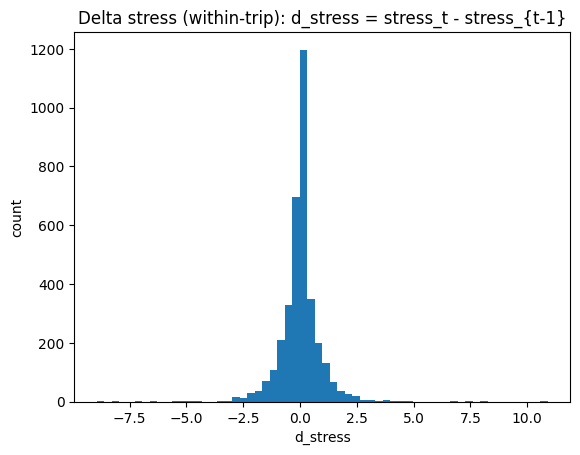

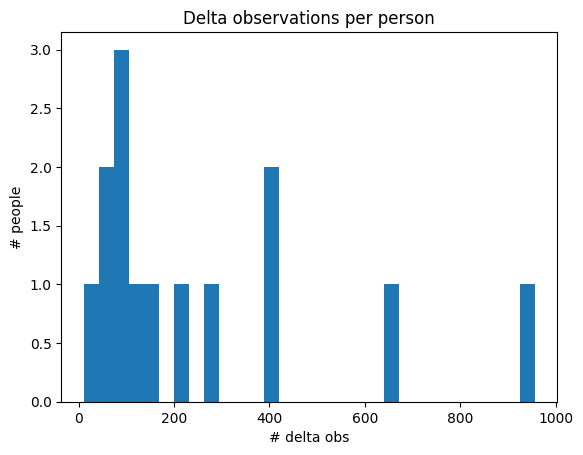

                            WLS Regression Results                            
Dep. Variable:               d_stress   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8242
Date:                Wed, 14 Jan 2026   Prob (F-statistic):              0.510
Time:                        21:59:42   Log-Likelihood:                -4613.8
No. Observations:                3566   AIC:                             9238.
Df Residuals:                    3561   BIC:                             9269.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0009 

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
diary_df = pd.read_pickle('/home/s232713/data/final_merged_data.pkl')

tress_df = pd.read_csv('/home/s232713/data/gps_trip_stress.csv')
env_df    = pd.read_csv('/home/s232713/data/foot_time_env.csv')

individ_list = [
    "MMM21201","MMM15201","MMM15601","MMM13401","MMM12601",
    "MMM12701","MMM12501","MMM24301","MMM22401","MMM23601",
    "MMM23901","MMM14101","MMM15801","MMM16301","MMM22501",
    "MMM14001","MMM14401","MMM15001","MMM14301"
] # best data infdividuals

participant_ids = (
    diary_df.loc[diary_df["INDIVID"].isin(individ_list), "Participant ID"]
    .unique()
)

print(f"Participant IDs: {participant_ids}")
stress_df = tress_df[tress_df["INDIVID"].isin(individ_list)]
env_df    = env_df[env_df["INDIVID"].isin(individ_list)]

stress_df["Timestamp"] = pd.to_datetime(stress_df["Timestamp"])
env_df["t_entry"] = pd.to_datetime(env_df["t_entry"])
env_df["t_exit"]  = pd.to_datetime(env_df["t_exit"])

ENV_VARS = ["grid_ndvi_mean","noise_L_mean","roads_transportation","buildings_facilities"]

# --- helper: time-weighted mean (your same idea) ---
def time_weighted_mean(x: pd.Series) -> float:
    if len(x) < 2:
        return np.nan
    dt = x.index.to_series().diff().dt.total_seconds()
    dt = x.index.to_series().diff().dt.total_seconds().to_numpy()
    if len(dt) > 1:
        dt[0] = dt[1]
    else:
        dt[0] = 0.0
    dt = np.clip(dt, 0.0, None)
    wsum = dt.sum()
    return float((x.to_numpy() * dt).sum() / wsum) if wsum > 0 else float(x.mean())

# --- Build episode table WITH t_entry to define ordering ---
all_eps = []
for INDIVID in stress_df["INDIVID"].dropna().unique():

    df_s = stress_df.loc[stress_df["INDIVID"] == INDIVID, ["Timestamp","stress_prob"]].copy()
    if len(df_s) < 10:
        continue
    df_s = df_s.set_index("Timestamp").sort_index()

    cols = ["INDIVID","Interval ID","t_entry","t_exit"] + ENV_VARS
    df_e = env_df.loc[env_df["INDIVID"] == INDIVID, cols].copy()
    if df_e.empty:
        continue
    df_e = df_e.sort_values("t_entry")

    rows = []
    for _, r in df_e.iterrows():
        t0, t1 = r["t_entry"], r["t_exit"]
        if pd.isna(t0) or pd.isna(t1) or t1 <= t0:
            continue

        mask = (df_s.index >= t0) & (df_s.index < t1)
        seg = df_s.loc[mask, "stress_prob"].dropna()
        if len(seg) < 3:
            continue

        dur = (t1 - t0).total_seconds()
        if dur < 20:
            continue

        rows.append({
            "INDIVID": INDIVID,
            "Interval ID": r["Interval ID"],
            "t_entry": t0,
            "t_exit": t1,
            "duration_sec": dur,
            "stress_mean": time_weighted_mean(seg),
            **{v: r[v] for v in ENV_VARS}
        })

    if len(rows) >= 10:
        all_eps.append(pd.DataFrame(rows))

df_ep = pd.concat(all_eps, ignore_index=True)
df_ep = df_ep.replace([np.inf, -np.inf], np.nan).dropna(subset=["stress_mean"] + ENV_VARS + ["duration_sec","t_entry","Interval ID","INDIVID"])

print("Episodes:", len(df_ep), "Individuals:", df_ep["INDIVID"].nunique())

# --- Within-person standardization ---
def zscore_safe(s: pd.Series) -> pd.Series:
    sd = s.std()
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.nan, index=s.index)
    return (s - s.mean()) / sd

df_ep["stress_mean_z"] = df_ep.groupby("INDIVID")["stress_mean"].transform(zscore_safe)
for v in ENV_VARS:
    df_ep[v] = df_ep.groupby("INDIVID")[v].transform(zscore_safe)

df_ep = df_ep.dropna(subset=["stress_mean_z"] + ENV_VARS)

# --- Define delta outcome within each trip (INDIVID + Interval ID) ---
df_ep = df_ep.sort_values(["INDIVID","Interval ID","t_entry"]).copy()
df_ep["stress_prev"] = df_ep.groupby(["INDIVID","Interval ID"])["stress_mean_z"].shift(1)
df_ep["d_stress"] = df_ep["stress_mean_z"] - df_ep["stress_prev"]

df_delta = df_ep.dropna(subset=["d_stress"]).copy()
print("Delta rows:", len(df_delta), "Trips:", df_delta["Interval ID"].nunique())

# --- Quick sanity plots ---
plt.figure()
plt.hist(df_delta["d_stress"], bins=60)
plt.title("Delta stress (within-trip): d_stress = stress_t - stress_{t-1}")
plt.xlabel("d_stress")
plt.ylabel("count")
plt.show()

delta_per_person = df_delta.groupby("INDIVID").size()
plt.figure()
plt.hist(delta_per_person, bins=30)
plt.title("Delta observations per person")
plt.xlabel("# delta obs")
plt.ylabel("# people")
plt.show()

# --- Fit Carlos delta model: d_stress ~ env (no lags) ---
y = df_delta["d_stress"]
X = sm.add_constant(df_delta[ENV_VARS])

# weights optional, keep them if you want longer episodes to count more
w = np.sqrt(df_delta["duration_sec"])

delta_model = sm.WLS(y, X, weights=w).fit(
    # cov_type="cluster",
    cov_kwds={"groups": df_delta["INDIVID"]}
)

print(delta_model.summary())